# Siamese model for whale identification #

Not completed because of two main complications:
* training results improve well on the training set, but model performs poorly on test set
* generating predictions for all test images takes estimated 27 days. This is assuming that to make a prediction on one test image, we have to compare that image to every training image.


In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input/"))

# Any results you write to the current directory are saved as output.

['humpback-whale-identification', 'traindfs', 'whale-train', 'traindf', 'testdf', 'traindf2']


In [2]:
# load libraries
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input
from keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler, CSVLogger
from PIL import Image
import cv2
from operator import itemgetter # for sorting python lists

Using TensorFlow backend.


In [3]:
# create targets
# note that all sets have the same alternating targets: 1, 0, 1, 0, etc.
# so, a single target set can be used for all training and testing sets
targets123 = np.zeros(200)
t = 0
for i in range(100):
    targets123[t] = 1
    t += 2
print(len(targets123))
targets123[0:5]

200


array([1., 0., 1., 0., 1.])

In [64]:
# create targets for the big set (3 times the length)
targets = np.zeros(600)
t = 0
for i in range(300):
    targets[t] = 1
    t += 2
print(len(targets))
targets[0:5]

600


array([1., 0., 1., 0., 1.])

In [ ]:
# create targets for the special same-label only set
targetss = np.ones(200)
targetss[0:5]

In [57]:
# Load previously saved dataframe
traindfs = pd.read_csv('../input/traindfs/traindfs.csv')
traindf1 = pd.read_csv('../input/traindf2/traindf1.csv')
traindf2 = pd.read_csv('../input/traindf2/traindf2.csv')
traindf3 = pd.read_csv('../input/traindf2/traindf3.csv')
testdf   = pd.read_csv('../input/traindf2/testdf.csv')

In [59]:
len(testdf)

200

## Create Tensors ##

In [6]:
# function to convert image to tensor
def img_to_tensor(img, size=(320,480)):
    '''
    img: path to image file
    size: (height, width)
    '''
    HEIGHT, WIDTH = size
    tensor = np.zeros((HEIGHT, WIDTH))
    # load image to PIL format
    img = Image.open(img)
    # convert to numpy array/tensor with shape (HEIGHT, WIDTH, 1)
    x = image.img_to_array(img)
    # min-max normalize
    xmin   = np.min(x)
    xmax   = np.max(x)
    xrange = xmax-xmin
    x      = (x-xmin)/xrange
    return x

In [7]:
def maketensors(df):
    '''
    Create tensors for siamese network
    '''
    n = len(df)
    array1 = np.zeros((n, 320, 480, 1))
    array2 = np.zeros((n, 320, 480, 1))
    path = '../input/whale-train/train_imgs/train/'
    i = 0
    for r in df.itertuples():
        array1[i] = img_to_tensor(path+r.Image1)
        array2[i] = img_to_tensor(path+r.Image2)
        i += 1
    return [array1, array2]

In [65]:
# make tensors
# traintss = maketensors(traindfs) # special tensor with positive pairs only
traints1 = maketensors(traindf1)
traints2 = maketensors(traindf2)
traints3 = maketensors(traindf3)
testts = maketensors(testdf)
# make a merged tensor, concatenate all 3 training sets
traints = maketensors(pd.concat([traindf1, traindf2, traindf3]))

In [9]:
# create one large training set and targets

train_all = maketensors(pd.concat([traindf1, traindf2, traindf3, testdf]))
targets_all = np.zeros(800)
t = 0
for i in range(400):
    targets_all[t] = 1
    t += 2
print(len(targets_all))

800


## Build Model ##
Siamese neural net

In [10]:
# load libraries
from keras.layers import Input, Conv2D, Lambda, merge, Dropout, Dense, Flatten, MaxPooling2D, GlobalMaxPooling2D
from keras.models import Model, Sequential
from keras.regularizers import l2
from keras import backend as K
from keras.optimizers import SGD,Adam
from keras.losses import binary_crossentropy
from keras.metrics import binary_accuracy
from keras.callbacks import LambdaCallback
from keras.layers import BatchNormalization

In [11]:
def score(predictions, targets):
    '''
    Compute accuracy
    '''
    n = len(targets)
    if len(predictions) != n:
        print('Both lists must be the same length.')
        return
    i = 0
    s = []
    for p in predictions:
        p = p[0]
        p = 1.0 if p>0.5 else 0.0
        t = targets[i]
        if p==t:
            s.append(1)
        else:
            s.append(0)
        i += 1
    return sum(s)/n

In [ ]:
# functions to initialize weights and bias per paper
# (do not seem to work well for me)

def initialize_weights(shape,name=None):
    """Initialize weights as in paper"""
    values = np.random.normal(loc=0,scale=1e-1,size=shape)
    return K.variable(values,name=name)

def initialize_bias(shape,name=None):
    """Initialize bias as in paper"""
    values=np.random.normal(loc=0,scale=1e-1,size=shape)
    return K.variable(values,name=name)

In [ ]:
# no longer using this
# alternative way to measure distance between two vectors

def euclidean_distance(vects):
    x, y = vects
    sum_square = K.sum(K.square(x - y), axis=1, keepdims=True)
    return K.sqrt(K.maximum(sum_square, K.epsilon()))

def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)

In [69]:
# model

input_shape = (320,480,1)

input_1 = Input(input_shape)
input_2 = Input(input_shape)

# convolution network to be used in each siamese branch
model = Sequential()
model.add(Conv2D(filters=64, 
                 kernel_size=2,
                 padding='same',
                 activation='relu', 
                 input_shape=input_shape,
                 #kernel_initializer='random_normal',
                 #kernel_initializer=initialize_weights,
                 kernel_regularizer=l2(0.0005) #2e-4
                ))
model.add(MaxPooling2D((2,2),strides=(2,2)))
# model.add(BatchNormalization())
model.add(Conv2D(filters=128,
                 kernel_size=2,
                 padding='same',
                 activation='relu',
                 #kernel_initializer='random_normal',
                 #kernel_initializer=initialize_weights,
                 #bias_initializer=initialize_bias, 
                 kernel_regularizer=l2(0.0005) #2e-4
                ))
model.add(MaxPooling2D((2,2),strides=(2,2)))
#model.add(BatchNormalization())
model.add(Conv2D(filters=256, 
                 kernel_size=2,
                 padding='same',
                 activation='relu',
                 #kernel_initializer='random_normal',
                 #kernel_initializer=initialize_weights,
                 #bias_initializer=initialize_bias, 
                 kernel_regularizer=l2(0.0005) #2e-4
                ))
#model.add(Flatten())
model.add(GlobalMaxPooling2D())
#model.add(Dropout(0.2))
model.add(Dense(512,
                activation='sigmoid',
                #kernel_initializer='random_normal',
                #kernel_initializer=initialize_weights,
                #bias_initializer=initialize_bias,
                #kernel_regularizer=l2(0.001) #1e-3
               ))

# Generate the encodings (feature vectors) for the two images
encoded_1 = model(input_1)
encoded_2 = model(input_2)

# distance = Lambda(euclidean_distance,output_shape=eucl_dist_output_shape)([encoded_1, encoded_2])

# Add a customized layer to compute the absolute difference between the encodings
l1_layer = Lambda(lambda tensors:K.abs(tensors[0] - tensors[1]))
l1_distance = l1_layer([encoded_1, encoded_2])

# Add a dense layer with a sigmoid unit to generate the similarity score
prediction = Dense(1,activation='sigmoid')(l1_distance)
# prediction = Dense(1,activation='sigmoid',bias_initializer=initialize_bias)(distance)
# prediction = Dense(1,activation='sigmoid')(distance)

# Connect the inputs with the outputs
siamese_model = Model(inputs=[input_1, input_2], outputs=prediction)

# Compile, summarize
siamese_model.compile(loss='binary_crossentropy',optimizer=Adam(lr=0.001),metrics=[binary_accuracy])
siamese_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 320, 480, 1)  0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            (None, 320, 480, 1)  0                                            
__________________________________________________________________________________________________
sequential_3 (Sequential)       (None, 512)          296128      input_5[0][0]                    
                                                                 input_6[0][0]                    
__________________________________________________________________________________________________
lambda_3 (Lambda)               (None, 512)          0           sequential_3[1][0]               
          

In [13]:
# folder to save model weights
os.mkdir('../input/model_weights')

In [ ]:
# save or load initial weights, if needed
model.save_weights('../input/model_weights/weights_initial_01.h5')
#model.load_weights('../input/model_weights/weights_initial_01.h5')

In [14]:
def lrschedule(epoch, lr):
    '''
    learning rate scheduler
    '''
    if epoch==10:
        lr=8e-4
    elif epoch==30:
        lr=6e-4
    elif epoch==50:
        lr=4e-4
    elif epoch==70:
        lr=2e-4
    elif epoch==90:
        lr=1e-4
    return lr

In [71]:
# train the model

EPOCHS = 50
BATCH_SIZE = 10
# callbacks
checkpointer = ModelCheckpoint(filepath='../input/model_weights/weights.02.h5',monitor='loss',verbose=1,save_best_only=True)
lrscheduler  = LearningRateScheduler(lrschedule,verbose=1)
earlystopper = EarlyStopping(patience=30,min_delta=1e-5,monitor='loss',restore_best_weights=True)
csvlogger    = CSVLogger('../input/model_weights/epochresults.csv',append=True)
history = siamese_model.fit(
        x=traints,
        y=targets,
        batch_size=BATCH_SIZE,
        epochs=EPOCHS,
        callbacks=[checkpointer,lrscheduler],
        validation_data=(testts, targets123),
        #validation_split=0.1,
        verbose=1)

Train on 600 samples, validate on 200 samples
Epoch 1/50

Epoch 00001: LearningRateScheduler setting learning rate to 0.0010000000474974513.
600/600 [==============================] - 29s 48ms/step - loss: 0.7520 - binary_accuracy: 0.4817 - val_loss: 0.7115 - val_binary_accuracy: 0.4750

Epoch 00001: loss improved from inf to 0.75200, saving model to ../input/model_weights/weights.02.h5
Epoch 2/50

Epoch 00002: LearningRateScheduler setting learning rate to 0.0010000000474974513.
600/600 [==============================] - 28s 46ms/step - loss: 0.7022 - binary_accuracy: 0.4900 - val_loss: 0.6972 - val_binary_accuracy: 0.4700

Epoch 00002: loss improved from 0.75200 to 0.70218, saving model to ../input/model_weights/weights.02.h5
Epoch 3/50

Epoch 00003: LearningRateScheduler setting learning rate to 0.0010000000474974513.
600/600 [==============================] - 28s 47ms/step - loss: 0.6955 - binary_accuracy: 0.4967 - val_loss: 0.6946 - val_binary_accuracy: 0.5050

Epoch 00003: loss i

600/600 [==============================] - 27s 46ms/step - loss: 0.6812 - binary_accuracy: 0.5967 - val_loss: 0.7357 - val_binary_accuracy: 0.4250

Epoch 00025: loss improved from 0.68282 to 0.68122, saving model to ../input/model_weights/weights.02.h5
Epoch 26/50

Epoch 00026: LearningRateScheduler setting learning rate to 0.0007999999797903001.
600/600 [==============================] - 27s 46ms/step - loss: 0.6857 - binary_accuracy: 0.5967 - val_loss: 0.7284 - val_binary_accuracy: 0.4200

Epoch 00026: loss did not improve from 0.68122
Epoch 27/50

Epoch 00027: LearningRateScheduler setting learning rate to 0.0007999999797903001.
600/600 [==============================] - 27s 46ms/step - loss: 0.6757 - binary_accuracy: 0.6200 - val_loss: 0.7443 - val_binary_accuracy: 0.4100

Epoch 00027: loss improved from 0.68122 to 0.67574, saving model to ../input/model_weights/weights.02.h5
Epoch 28/50

Epoch 00028: LearningRateScheduler setting learning rate to 0.0007999999797903001.
600/600 [==


Epoch 00049: loss improved from 0.56098 to 0.54030, saving model to ../input/model_weights/weights.02.h5
Epoch 50/50

Epoch 00050: LearningRateScheduler setting learning rate to 0.0006000000284984708.
600/600 [==============================] - 27s 46ms/step - loss: 0.5281 - binary_accuracy: 0.7833 - val_loss: 1.0840 - val_binary_accuracy: 0.4250

Epoch 00050: loss improved from 0.54030 to 0.52813, saving model to ../input/model_weights/weights.02.h5


In [ ]:
# save or load initial weights, if needed
model.save_weights('../input/model_weights/weights_02.h5')
#model.load_weights('../input/model_weights/weights_initial_01.h5')

In [70]:
# initial prediction accuracies for each subsets
# (run this before training)
preds1 = siamese_model.predict(traints1)
preds2 = siamese_model.predict(traints2)
preds3 = siamese_model.predict(traints3)
preds4 = siamese_model.predict(testts)
print('set1: ', score(preds1, targets123))
print('set2: ', score(preds2, targets123))
print('set3: ', score(preds3, targets123))
print('test: ', score(preds4, targets123))

set1:  0.48
set2:  0.515
set3:  0.54
test:  0.525


In [72]:
# post-training prediction accuracies for each subsets
# (run this after training)
preds1 = siamese_model.predict(traints1)
preds2 = siamese_model.predict(traints2)
preds3 = siamese_model.predict(traints3)
preds4 = siamese_model.predict(testts)
print('set1: ', score(preds1, targets123))
print('set2: ', score(preds2, targets123))
print('set3: ', score(preds3, targets123))
print('test: ', score(preds4, targets123))

set1:  0.79
set2:  0.82
set3:  0.79
test:  0.425


In [19]:
# just to see how predictions probabilities look
print(preds1)

[[9.87488151e-01]
 [1.79087482e-02]
 [9.34724987e-01]
 [7.75216904e-05]
 [9.94837701e-01]
 [1.48021635e-02]
 [9.91269588e-01]
 [9.34009533e-03]
 [9.90145743e-01]
 [1.21781351e-02]
 [9.93284106e-01]
 [2.06971448e-02]
 [9.91507113e-01]
 [1.32358512e-02]
 [9.91170824e-01]
 [4.19896692e-02]
 [9.84160483e-01]
 [9.63197835e-03]
 [9.72609282e-01]
 [1.17071547e-01]
 [9.68135893e-01]
 [4.15266317e-04]
 [9.95008945e-01]
 [2.23281533e-02]
 [9.78314757e-01]
 [3.17351660e-03]
 [9.94483769e-01]
 [1.39381168e-02]
 [9.22051489e-01]
 [1.85721542e-03]
 [9.93319511e-01]
 [6.77882284e-02]
 [9.76348102e-01]
 [5.20107429e-03]
 [9.91271377e-01]
 [5.97395888e-03]
 [9.99472201e-01]
 [2.52538211e-05]
 [9.56276536e-01]
 [4.83698968e-05]
 [9.87852931e-01]
 [1.03866414e-03]
 [9.84662294e-01]
 [4.51886607e-03]
 [9.82245564e-01]
 [3.61354649e-02]
 [9.96559083e-01]
 [4.78843711e-02]
 [9.93607640e-01]
 [1.35050272e-03]
 [9.75221217e-01]
 [3.29716988e-02]
 [9.81575727e-01]
 [4.37444635e-03]
 [9.78236258e-01]
 [2.880267

In [ ]:
print(history.history.keys())

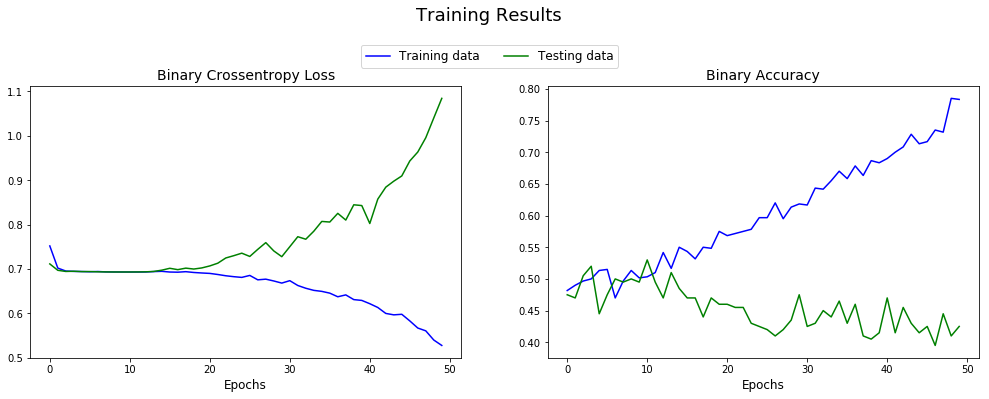

In [73]:
#import matplotlib.lines as mlines

val_loss = history.history['val_loss']
val_binary_acc = history.history['val_binary_accuracy']
loss = history.history['loss']
binary_acc = history.history['binary_accuracy']

blue_line  = mlines.Line2D([],[],color='blue',label='Training data')
green_line = mlines.Line2D([],[],color='green',label='Testing data')

fig, ax = plt.subplots(nrows=1,ncols=2,figsize=(17,5))
fig.suptitle('Training Results',x=0.5,y=1.1,fontsize=18)
fig.legend(handles=[blue_line,green_line],loc=9,ncol=2,fontsize=12,bbox_to_anchor=(0.4,1))

ax[0].set_title('Binary Crossentropy Loss', fontsize=14)
ax[0].set_xlabel('Epochs', fontsize=12)
# ax[0].ylim(0,2.0)
ax[0].plot(loss, 'b')
ax[0].plot(val_loss, 'g')

ax[1].set_title('Binary Accuracy', fontsize=14)
ax[1].set_xlabel('Epochs', fontsize=12)
# ax[1].ylim(0,2.0)
ax[1].plot(binary_acc, 'b')
ax[1].plot(val_binary_acc, 'g')

In [ ]:
# save or load weights, as needed
model.save_weights('../input/model_weights/weights_01.h5')
model.load_weights('../input/weights_01.h5')

## Testing and submission to Kaggle ##

In [21]:
traindf = pd.read_csv('../input/traindf/traindf.csv')
traindf.drop(['Processed', 'Attention'], axis=1, inplace=True)
print(traindf.head(3))
print(len(traindf))

           Image         Id
0  0000e88ab.jpg  w_f48451c
1  0001f9222.jpg  w_c3d896a
2  00029d126.jpg  w_20df2c5
15697


In [22]:
# load test files into dataframe
filelist = os.listdir('../input/testdf/test/test')
testdf = pd.DataFrame(filelist, columns=['Image'])
print(testdf.head(3))
print(len(testdf))

           Image
0  009dd6c96.jpg
1  2a73b60f7.jpg
2  4d2f1d959.jpg
7960


In [23]:
def make_test_input(test_img,train_img):
    '''
    Create tensor input for testing in siamese model
    '''
    array1 = np.zeros((1, 320, 480, 1))
    array2 = np.zeros((1, 320, 480, 1))
    train_path = '../input/whale-train/train_imgs/train/'
    test_path  = '../input/testdf/test/test/'
    array1[0] = img_to_tensor(test_path  + test_img)
    array2[0] = img_to_tensor(train_path + train_img)
    return [array1, array2]

In [ ]:
# just testing
one_example = make_test_input(test_img='009dd6c96.jpg',train_img='0000e88ab.jpg')
pred = siamese_model.predict(one_example)
print(pred)  # [[0.50168335]]

In [29]:
# put all training labels and images into separate arrays
labels = np.array(traindf.Id)
images = np.array(traindf.Image)

In [30]:
# code to make prediction for all test images

import datetime

j = 0
for test_img in testdf.Image:
    i = 0
    t_start = datetime.datetime.now()
    preds = np.zeros(len(traindf))
    for train_img in traindf.Image:
        test_tensor = make_test_input(test_img,train_img)
        pred = siamese_model.predict(test_tensor)
        preds[i] = pred
        i += 1
        # if i%1000==0:
            # print('processing img {}'.format(i))
    # get index of best 5 predictions, with best listed first
    inx = np.argsort(preds)[-5:][::-1].tolist()
    predicted_labels = labels[inx].tolist()
    predicted_images = images[inx].tolist()
    predicted_probabilities = preds[inx].tolist()
    t_end = datetime.datetime.now()
    t_diff = t_end-t_start
    
    # look at results
    print('test image:', test_img)
    print('best 5 predictions (images)',predicted_images)
    print('best 5 predictions (labels)',predicted_labels)
    print('probabilities:', predicted_probabilities)
    print('execution time (in seconds):', t_diff.seconds)
    print('')
    
    # run for only 2 loops (2 test images) to check things
    j += 1
    if j>=2:
        break

test image: 009dd6c96.jpg
best 5 predictions (images) ['c0f29c6b1.jpg', 'c7aa4e79a.jpg', '23d2dff49.jpg', '569cfb0c3.jpg', '82efb5d40.jpg']
best 5 predictions (labels) ['w_789c969', 'w_0718183', 'w_f6c5343', 'w_38c6a8d', 'w_f0fe284']
probabilities: [0.9999998807907104, 0.9999995231628418, 0.9999994039535522, 0.9999991655349731, 0.9999990463256836]
execution time (in seconds): 332

test image: 2a73b60f7.jpg
best 5 predictions (images) ['c0f29c6b1.jpg', '31b640d52.jpg', 'a12b720e8.jpg', '3481cc906.jpg', '6311688b7.jpg']
best 5 predictions (labels) ['w_789c969', 'w_ce1bf27', 'w_6822dbc', 'w_5a2634c', 'w_1403973']
probabilities: [0.9999985694885254, 0.9999964237213135, 0.9999960660934448, 0.9999960660934448, 0.9999958276748657]
execution time (in seconds): 328



In [ ]:
# above code takes 5 minutes to make a prediction on one test image
# to make prediction on all 7960 test images, it will take 7960 x 5 mins / 60 mins / 24 hrs = 28 days

In [49]:
# function to view images

def show_imgs(imgs, labels, title=None):
    '''
    plots the images in 3 columns (number of rows will vary).
    '''
    n = len(imgs)
    y = max(1, n//3) + (1 if (n//3>0 and n%3>0) else 0)
    x = n if n<3 else 3
    fig, ax = plt.subplots(nrows=y, ncols=x, figsize=(15,y*4))
    if title:
        fig.suptitle(title, fontsize=16)
    if labels is None:
        labels = ['unlabeled' for i in range(n)]
    titles = ['{} - {}'.format(a[-13:], b) for a, b in zip(imgs, labels)]
    m = 0
    for i in range(y):
        for j in range(x):
            if m >= n:
                break
            img = Image.open(imgs[m])
            if y==1:
                ax[j].imshow(img)
                ax[j].set(title=titles[m])
            else:
                ax[i,j].imshow(img)
                ax[i,j].set(title=titles[m])
            m += 1

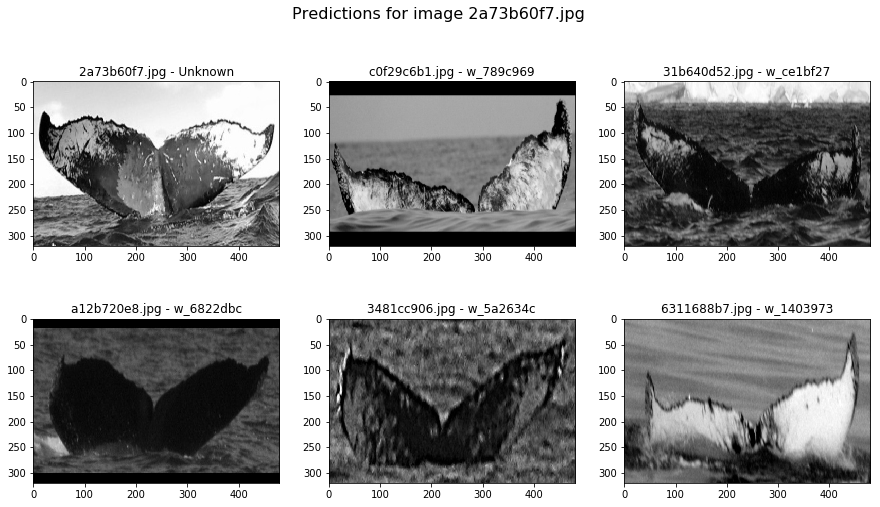

In [51]:
group1 = ['../input/testdf/test/test/009dd6c96.jpg',
          '../input/whale-train/train_imgs/train/c0f29c6b1.jpg',
          '../input/whale-train/train_imgs/train/c7aa4e79a.jpg',
          '../input/whale-train/train_imgs/train/23d2dff49.jpg',
          '../input/whale-train/train_imgs/train/569cfb0c3.jpg',
          '../input/whale-train/train_imgs/train/82efb5d40.jpg']
labels1 = ['Unknown', 'w_789c969', 'w_0718183', 'w_f6c5343', 'w_38c6a8d', 'w_f0fe284']
group2 = ['../input/testdf/test/test/2a73b60f7.jpg',
          '../input/whale-train/train_imgs/train/c0f29c6b1.jpg',
          '../input/whale-train/train_imgs/train/31b640d52.jpg',
          '../input/whale-train/train_imgs/train/a12b720e8.jpg',
          '../input/whale-train/train_imgs/train/3481cc906.jpg',
          '../input/whale-train/train_imgs/train/6311688b7.jpg']
labels2 = ['Unknown', 'w_789c969', 'w_ce1bf27', 'w_6822dbc', 'w_5a2634c', 'w_1403973']

#show_imgs(group1, labels1, 'Predictions for image 009dd6c96.jpg')
show_imgs(group2, labels2, 'Predictions for image 2a73b60f7.jpg')